In [30]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import AE
from models import DNN
import numpy as np
import pandas as pd

In [31]:
from scipy.stats import pearsonr

# Parameters

In [32]:
# Define parameters
epochs = 500 #200,500,1000
dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1

# Import data

In [33]:
data_r=pd.read_csv('data/GDSCexpression.csv',index_col=0)
label_r=pd.read_csv('data/GDSClabel.csv',index_col=0)

In [34]:
label_r=label_r.fillna(1)

# Your is gene-cell, mine is cell-gene

In [35]:
len(set(data_r.index))

727

In [36]:
data = data_r
label = label_r.iloc[:,10]
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
data = scaler.fit_transform(data)

In [37]:
print(np.std(data))
print(np.mean(data))

0.9999999999999997
6.316789844568889e-19


In [38]:
data.shape

(789, 11833)

In [39]:
label_r.shape

(789, 139)

# Split test train

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [41]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(789, 11833)
(789,)
(631, 11833) (631,)
(158, 11833) (158,)


In [42]:
print(X_train.max())
print(X_train.min())

23.78951596267762
-17.277718272630676


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [44]:
trainData = torch.FloatTensor(X_train).to(device)
testData = torch.FloatTensor(X_test).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
allData = torch.FloatTensor(data).to(device)

# construct TensorDataset
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
all_dataset = TensorDataset(allData, allData)

trainDataLoader1 = DataLoader(dataset=train_dataset, batch_size=200, shuffle=False)
trainDataLoaderall = DataLoader(dataset=all_dataset, batch_size=200, shuffle=False)

# The model

In [45]:
# Initialization

#autoencoder = AE(dim=train_dataset.shape[1]).to(device)
autoencoder = AE(dim_au_in = X_train.shape[1],dim_au_out=dim_au_out).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
#loss1
loss_func = nn.SmoothL1Loss().to(device)
#loss2
#loss_func = nn.BCELoss()
loss_train = np.zeros((epochs, 1))

In [46]:
# Train autoencoder

for epoch in range(epochs):
    # 不需要label，所以用一个占位符"_"代替
    for batchidx, (x, _) in enumerate(trainDataLoaderall):
        x.requires_grad_(True)
        # encode and decode 
        decoded, encoded = autoencoder(x)
        # compute loss
        print(encoded.shape, decoded.shape)
        loss = loss_func(decoded, x)      
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0001, Training loss=0.39301664
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0002, Training loss=0.38971776
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0003, Training loss=0.38967171
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0004, Training loss=0.38970920
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Siz

Epoch: 0036, Training loss=0.37572005
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0037, Training loss=0.37517685
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0038, Training loss=0.37454379
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0039, Training loss=0.37410015
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0040, Training loss=0.37348199
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0073, Training loss=0.34290409
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0074, Training loss=0.34238413
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0075, Training loss=0.34112290
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0076, Training loss=0.34022176
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0077, Training loss=0.33888590
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0109, Training loss=0.31264356
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0110, Training loss=0.31117055
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0111, Training loss=0.30978265
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0112, Training loss=0.30863756
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0113, Training loss=0.30761540
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0145, Training loss=0.29822111
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0146, Training loss=0.29775223
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0147, Training loss=0.29743665
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0148, Training loss=0.29669592
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0149, Training loss=0.29620379
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0182, Training loss=0.28974050
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0183, Training loss=0.28963575
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0184, Training loss=0.28967333
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0185, Training loss=0.28975058
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0186, Training loss=0.28969920
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0218, Training loss=0.28443921
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0219, Training loss=0.28433108
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0220, Training loss=0.28423089
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0221, Training loss=0.28406233
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0222, Training loss=0.28378242
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0254, Training loss=0.28020549
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0255, Training loss=0.28035551
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0256, Training loss=0.28027001
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0257, Training loss=0.27999118
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0258, Training loss=0.27967688
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0290, Training loss=0.27603081
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0291, Training loss=0.27577442
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0292, Training loss=0.27557319
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0293, Training loss=0.27551845
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0294, Training loss=0.27538815
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0327, Training loss=0.27274242
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0328, Training loss=0.27259383
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0329, Training loss=0.27250436
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0330, Training loss=0.27239460
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0331, Training loss=0.27234444
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0363, Training loss=0.27029443
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0364, Training loss=0.27016538
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0365, Training loss=0.27004117
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0366, Training loss=0.26998407
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0367, Training loss=0.26992258
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0399, Training loss=0.26813760
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0400, Training loss=0.26820296
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0401, Training loss=0.26818353
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0402, Training loss=0.26787505
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0403, Training loss=0.26782638
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0435, Training loss=0.26634520
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0436, Training loss=0.26633647
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0437, Training loss=0.26630083
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0438, Training loss=0.26620841
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0439, Training loss=0.26612139
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0471, Training loss=0.26490724
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0472, Training loss=0.26475304
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0473, Training loss=0.26465109
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0474, Training loss=0.26457626
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0475, Training loss=0.26451921
torch.Size([200, 512]) torch.Size([200, 11

In [47]:
torch.save(autoencoder.state_dict(), 'saved/models/AE_GDSC.pkl')

In [48]:
# extract features
_, encodedTrainData = autoencoder(trainData)
featureTensor = encodedTrainData.double()
feature = featureTensor.detach().cpu().numpy()

In [49]:
print(feature.shape)

(631, 512)


In [50]:
feature

array([[-13.64498901, -45.12091827,  18.96537018, ...,  14.36603832,
         -2.69179845,  16.28588676],
       [ -3.69213533,  22.82785225,   9.8851099 , ...,  42.63671875,
         -6.24446297,  78.920578  ],
       [  0.08489308,  16.38222504,   1.90580785, ..., -23.28546715,
        -30.29092979,  46.03081131],
       ...,
       [  6.75188732,   8.96682262, -20.5747757 , ...,   7.93260574,
        -33.50723648,   1.88835776],
       [  3.33180881,  -1.979316  , -26.14553833, ..., -10.36104584,
        -33.92246628,  28.36135101],
       [ -1.09352887,  13.92858887,  -1.33011389, ...,  24.29382515,
          0.7713114 ,   4.64399719]])

In [51]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(feature, Y_train.values)

Lasso(alpha=0.1)

In [52]:
_,testFeature = autoencoder(testData)
lasso = clf.predict(testFeature.detach().cpu().numpy())

In [53]:
r2_score(lasso,Y_test)

-3.219983747839726

In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 631 samples in 0.031s...
[t-SNE] Computed neighbors for 631 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 631 / 631
[t-SNE] Mean sigma: 129.415853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.580544
[t-SNE] KL divergence after 300 iterations: 1.617151


In [55]:
tsne_results

array([[-4.6817093, -7.3840218],
       [ 6.094573 , -5.2347307],
       [-1.1985868,  3.6367145],
       ...,
       [-6.1208696, -1.320755 ],
       [-3.2816222,  7.754547 ],
       [12.606026 , -5.548164 ]], dtype=float32)

FileNotFoundError: [Errno 2] No such file or directory: 'saved/figrues/tsne_ae_gdsc.png'

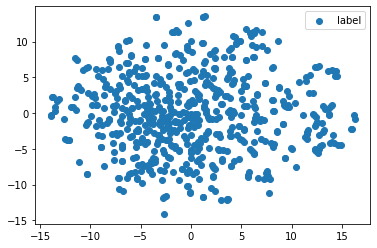

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figrues/tsne_ae_gdsc.png")

In [57]:
EPOCH = 500

In [58]:
# Load data
# data type conversion
B_feature = torch.FloatTensor(feature).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
# construct TensorDataset
b_data = TensorDataset(B_feature, y)
trainDataLoader2 = DataLoader(dataset=b_data, batch_size=200, shuffle=False)

In [59]:
b_data.tensors

(tensor([[-13.6450, -45.1209,  18.9654,  ...,  14.3660,  -2.6918,  16.2859],
         [ -3.6921,  22.8279,   9.8851,  ...,  42.6367,  -6.2445,  78.9206],
         [  0.0849,  16.3822,   1.9058,  ..., -23.2855, -30.2909,  46.0308],
         ...,
         [  6.7519,   8.9668, -20.5748,  ...,   7.9326, -33.5072,   1.8884],
         [  3.3318,  -1.9793, -26.1455,  ..., -10.3610, -33.9225,  28.3614],
         [ -1.0935,  13.9286,  -1.3301,  ...,  24.2938,   0.7713,   4.6440]],
        device='cuda:0'),
 tensor([4.1360e-03, 2.4651e-01, 1.0000e+00, 1.6831e-01, 2.4553e-01, 4.5574e-02,
         5.6766e-01, 6.5160e-03, 5.1101e-02, 1.0000e+00, 1.0000e+00, 1.3382e-01,
         8.5730e-03, 2.0783e-02, 7.1891e-02, 2.6463e-02, 2.0267e-01, 1.6792e-01,
         2.2742e-01, 5.1173e-01, 5.5870e-02, 9.3305e-02, 3.9400e-03, 9.9018e-02,
         1.0000e+00, 7.3892e-02, 1.1134e-02, 8.2544e-02, 1.1754e-02, 1.4302e-01,
         1.0000e+00, 1.0000e+00, 2.4001e-02, 3.9460e-03, 7.5210e-03, 4.9375e-01,
         7.

In [60]:
b_data

In [ ]:
dim_dnn_in

In [ ]:
# Initialization DNN model

predictor = DNN(dim_dnn_in, dim_dnn_out).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=1e-3,betas=(0.9,0.99))
#loss1-softmax
#loss_func = nn.MSELoss().to(device)
#loss2-sigmoid
loss_func = nn.BCELoss().to(device)
#loss3-sigmoid
#loss_func = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=True)
#criterion = torch.nn.BCELoss(size_average=True) # Defined loss function
#optimizer = optim.Adm(model.parameters(), lr=0.01) # Defined optimizer
loss_train = np.zeros((epochs, 1))

In [ ]:
# train model
for epoch in range(EPOCH):
    print('Epoch: ',epoch)
    for step,(batch_x,batch_y) in enumerate(trainDataLoader2):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        # predict label
        output = predictor(b_x)
        # b_y=F.sigmoid(b_y) 
        
        #print
        #print(output)
        #print(b_y)
        # compute loss
        loss = loss_func(output,b_y)
        #loss = criterion(output, b_y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item())) 

# Save model
torch.save(predictor.state_dict(), 'saved/models/DNN_GDSC.pkl')

In [ ]:
# Get tesing feature
_,testFeature = autoencoder(testData)

In [ ]:
testpredict = predictor(testFeature)

In [ ]:
testpredict

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
r2_score(testpredict.detach().cpu().numpy(),Y_test)

In [ ]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)